### **Data preprocessing**

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.stats import zscore
import os
from tensorflow.keras.utils import get_file
from sklearn.preprocessing import normalize # , LabelEncoder

# Read the info about features
try:
    path = get_file('NUSW-NB15_features.csv', origin='https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/NUSW-NB15_features.csv')
except:
    print('Error downloading')
    raise

# Read the info about features
print('Reading feature info...')
data_info = pd.read_csv(path, encoding = "ISO-8859-1", header=None).values
features = data_info[1:-2,:]
feature_names = features[:, 1]  # Names of the features in a list
feature_types = np.array([item.lower() for item in features[:, 2]])  # The types of the corresponding features in 'features_names'
                         
# index arrays for different types of features
print('Finding column indices for feature types...')
nominal_cols = np.where(feature_types == "nominal")[0]
integer_cols = np.where(feature_types == "integer")[0]
binary_cols = np.where(feature_types == "binary")[0]
float_cols = np.where(feature_types == "float")[0]

# arrays for names of the different types of features
nominal_names = feature_names[nominal_cols]
integer_names = feature_names[integer_cols]
binary_names = feature_names[binary_cols]
float_names = feature_names[float_cols]

print('Reading csv file...')
#dataframe = pandas.read_csv("UNSW.csv", header=None)
df = pd.read_csv("/content/drive/My Drive/UNSW.csv", header=None)

print('Preprocessing...')
print('Converting data...')
df[integer_cols] = df[integer_cols].apply(pd.to_numeric, errors='coerce')
df[binary_cols] = df[binary_cols].apply(pd.to_numeric, errors='coerce')
df[float_cols] = df[float_cols].apply(pd.to_numeric, errors='coerce')
df[48] = df[48].apply(pd.to_numeric, errors='coerce')
#dataframe[nominal_cols] = dataframe[nominal_cols].astype(str)

print('Replacing NaNs...')
df.loc[:,47] = df.loc[:,47].replace(np.nan,'normal', regex=True).apply(lambda x: x.strip().lower())
df.loc[:,binary_cols] = df.loc[:,binary_cols].replace(np.nan, 0, regex=True)
df.loc[:,37:39] = df.loc[:,37:39].replace(np.nan, 0, regex=True)
# dataframe.loc[:,float_cols] = dataframe.loc[:,float_cols].replace(np.nan, 0, regex=True)

print('Stripping nominal columns and setting them lower case...')
df.loc[:,nominal_cols] = df.loc[:,nominal_cols].applymap(lambda x: x.strip().lower())

print('Changing targets \'backdoors\' to \'backdoor\'...')
df.loc[:,47] = df.loc[:,47].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

print('Adding column headers...')
col = [
    'Srcip',
    'Sport',
    'Dstip',
    'Dsport',
    'Proto',
    'State',
    'Dur',
    'sbytes',
    'dbytes',
    'Sttl',
    'Dttl',
    'Sloss',
    'dloss',
    'service',
    'sload',
    'dload',
    'spkts',
    'dpkts',
    'Swin',
    'Dwin',
    'Stcpb',
    'Dtcpb',
    'Smeansz',
    'Dmeansz',
    'trans_depth',
    'res_bdy_len',
    'Sjit',
    'Djit',
    'Stime',
    'Ltime',
    'Sintpkt',
    'Dintpkt',
    'Tcprtt',
    'Synack',
    'Ackdat',
    'is_sm_ips_ports',
    'ct_state_ttl',
    'ct_flw_http_mthd',
    'is_ftp_login',
    'ct_ftp_cmd',
    'ct_srv_src',
    'ct_srv_dst',
    'ct_dst_ltm',
    'ct_src_ltm',
    'ct_src_dport_ltm',
    'ct_dst_sport_ltm',
    'ct_dst_src_ltm',
    'attack_cat',
    'Label'
]
df.columns = col

print('Copying values...')
dataset = df.values

# display 5 rows
print('Printing 5 rows of the processed dataframe...')
df[0:5]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading feature info...
Finding column indices for feature types...
Reading csv file...


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Preprocessing...
Converting data...
Replacing NaNs...
Stripping nominal columns and setting them lower case...
Changing targets 'backdoors' to 'backdoor'...
Adding column headers...
Copying values...
Printing 5 rows of the processed dataframe...


,Srcip,Sport,Dstip,Dsport,Proto,State,Dur,sbytes,dbytes,Sttl,Dttl,Sloss,dloss,service,sload,dload,spkts,dpkts,Swin,Dwin,Stcpb,Dtcpb,Smeansz,Dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,Tcprtt,Synack,Ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390.0,149.171.126.6,53.0,udp,con,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0.0,3,7,1,3,1,1,1,normal,0
1,59.166.0.0,33661.0,149.171.126.9,1024.0,udp,con,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0.0,2,4,2,3,1,1,2,normal,0
2,59.166.0.6,1464.0,149.171.126.7,53.0,udp,con,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0.0,12,8,1,2,2,1,1,normal,0
3,59.166.0.5,3593.0,149.171.126.5,53.0,udp,con,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0.0,6,9,1,1,1,1,1,normal,0
4,59.166.0.3,49664.0,149.171.126.0,53.0,udp,con,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0.0,7,9,1,1,1,1,1,normal,0


## **Transforming into numeric**

In [0]:
# Subsets of the dataset which have data that is only of the corresponding data type (nominal, integer etc)
# Columns don't include the target classes (the two last columns of the dataset)
print('Slicing dataset...')
nominal_x = dataset[:, nominal_cols][:,:]
integer_x = dataset[:, integer_cols][:,:].astype(np.float32)    
binary_x = dataset[:, binary_cols][:,:].astype(np.float32)
float_x = dataset[:, float_cols][:,:].astype(np.float32)

# Make nominal (textual) data binary vectors
print('Vectorizing nominal data...')
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
# D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
D = map(lambda dataline: dict(zip(nominal_names, dataline)), nominal_x)
labeled_nominal_x = v.fit_transform(D).astype(np.float32)
del nominal_x

print('Concatenating X...')
X = np.concatenate((integer_x, labeled_nominal_x, float_x, binary_x), axis=1)

del integer_x
del labeled_nominal_x
del float_x
del binary_x

# Find rows that have NaNs
print('Removing NaNs if any...')
nan_indices = []
for feature_i in range(X.shape[1]):
    nan_indices.extend(list(np.where(np.isnan(X[:, feature_i]))[0]))
nan_indices = np.unique(nan_indices)

# Remove rows that have NaNs
X_no_nans = np.delete(X, nan_indices, axis=0)

del X

print('Normalizing X...')
normalized_X = normalize(X_no_nans, copy=False)

del X_no_nans


data_dim = normalized_X.shape
print('Data dimensions are', data_dim)

print('Creating target Y matrix...')
Y = np.delete(dataset[:, -2], nan_indices)
Y_A = np.delete(dataset[:, -1], nan_indices).astype(np.int16) # Is attack or not

del dataset

print('Vectorizing Y labels...')
D = [{'attack_cat': y} for y in Y]
labeled_Y = v.fit_transform(D)

del D

print('Done')

Slicing dataset...
Vectorizing nominal data...
Concatenating X...
Removing NaNs if any...
Normalizing X...
Data dimensions are (2539739, 294)
Creating target Y matrix...
Vectorizing Y labels...
Done


## **Train the Neural Network**

In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
import timeit
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

#Custom Metrics
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Create a test/train split. 50% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    normalized_X, labeled_Y, test_size=0.5, random_state=42)

num_of_features = x_train.shape[1] #294 features
nb_classes = y_train.shape[1] #10 detected actions

# Reshaping x_train and x_test for efficient modelling
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Model
model = Sequential()

model.add(LSTM(50, input_shape=(num_of_features,1), return_sequences=False))
model.add(Dense(nb_classes,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')

startTime = timeit.default_timer()
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=8,batch_size=1024)
elapsedTime = timeit.default_timer() - startTime

print("Time taken for the Network to train:",elapsedTime)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1269869 samples, validate on 1269870 samples
Epoch 1/8
1269869/1269869 [==============================] - 1401s 1ms/sample - loss: 0.5505 - acc: 0.8729 - precision_m: 0.8588 - recall_m: 0.8588 - f1_m: 0.8588 - val_loss: 0.5225 - val_acc: 0.8734 - val_precision_m: 0.8735 - val_recall_m: 0.8735 - val_f1_m: 0.8735
Epoch 2/8
1269869/1269869 [==============================] - 1404s 1ms/sample - loss: 0.5208 - acc: 0.8736 - precision_m: 0.8736 - recall_m: 0.8736 - f1_m: 0.8736 - val_loss: 0.5083 - val_acc: 0.8734 - val_precision_m: 0.8734 - val_recall_m: 0.8734 - val_f1_m: 0.8734
Epoch 3/8
1269869/1269869 [==============================] - 1412s 1ms/sample - loss: 0.4116 - acc: 0.8728 - precision_m: 0.9184 - recall_m: 0.8315 - f1_m: 0.8703 - val_loss: 0.3522 - val_acc: 0.8734 - val_precision_m: 0.9691 - val_rec

## **Plotting & Evaluating Metrics**

Evaluating...
Plotting the metrics...


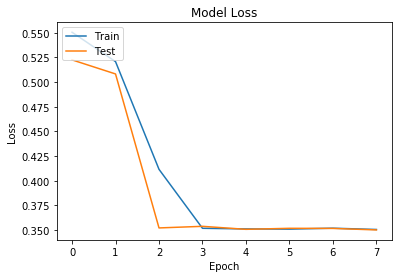

Loss: 35.02%


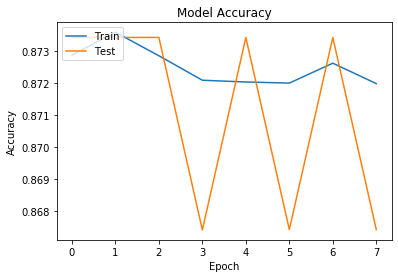

Accuracy: 86.74%


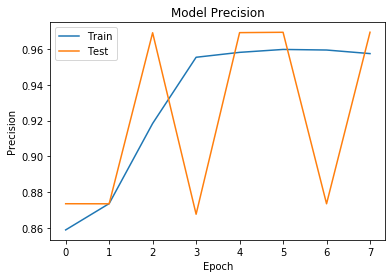

Precision: 96.94%


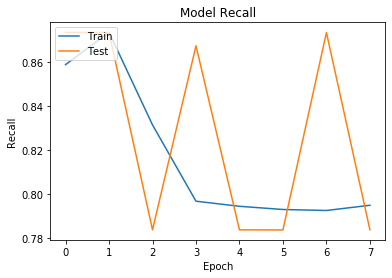

Recall: 78.38%


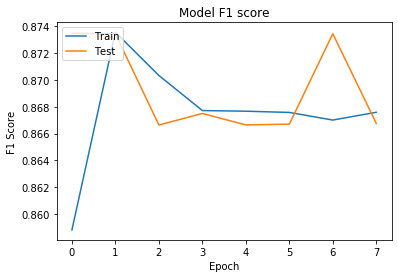

F1 Score: 86.67%

Final Score...
Validation/Final Score: 86.74%


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Evaluating
print("Evaluating...")
loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test, verbose=0, batch_size=1024)

print("Plotting the metrics...")
plt.rcParams["figure.figsize"] = [6,4]

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Loss: %.2f%%' % (loss*100))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Accuracy: %.2f%%' % (accuracy*100))

# Plot training & validation precision values
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Precision: %.2f%%' % (precision*100))

# Plot training & validation recall values
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Recall: %.2f%%' % (recall*100))

# Plot training & validation f1 score values
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('F1 Score: %.2f%%' % (f1_score*100))


# Final Score
print('\nFinal Score...')
y_p = model.predict(x_test)
y_pred = np.argmax(y_p,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row
y_eval = np.argmax(y_test,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row
score = accuracy_score(y_eval, y_pred)
print('Validation/Final Score: %.2f%%' % (score*100))

## **Confusion Matrix**

Confusion matrix, without normalization
[[     0      0      0      0      0    985    370      0      0      0]
 [     0      0      0      0      0    883    298      0      0      0]
 [     0      0      0      0      0   5706   2464      0      0      0]
 [     0      0      0      0      0   7345  14862      0      0      0]
 [     0      0      0      0      0   3997   8097      0      0      0]
 [     0      0      0      0      0 106153   1761      0      0      0]
 [     0      0      0      0      0 113754 995372      0      0      0]
 [     0      0      0      0      0   3337   3658      0      0      0]
 [     0      0      0      0      0    373    365      0      0      0]
 [     0      0      0      0      0     12     78      0      0      0]]


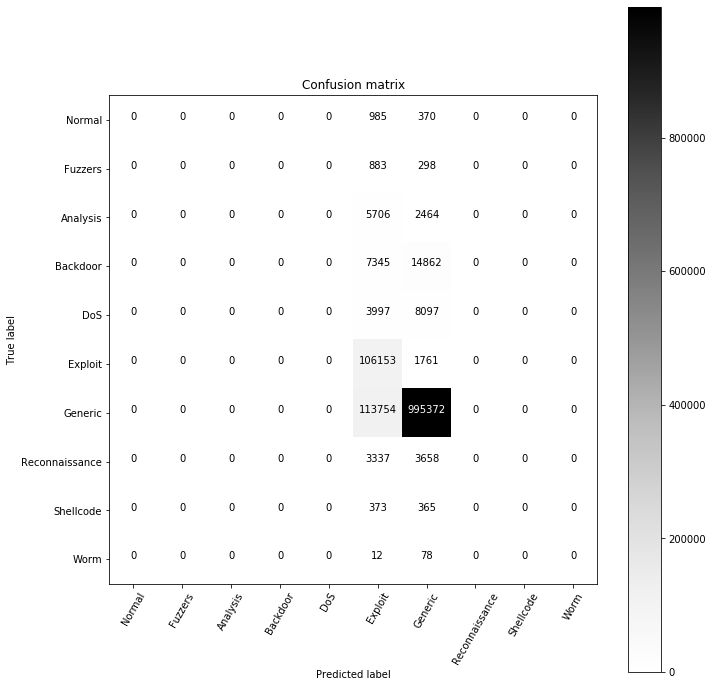

Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.72693727
  0.27306273 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.74767146
  0.25232854 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.69840881
  0.30159119 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.33075156
  0.66924844 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.33049446
  0.66950554 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.98368145
  0.01631855 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.10256184
  0.89743816 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.47705504
  0.52294496 0.         0.         0.        ]
 [0.         0.         0.         0.         0.    

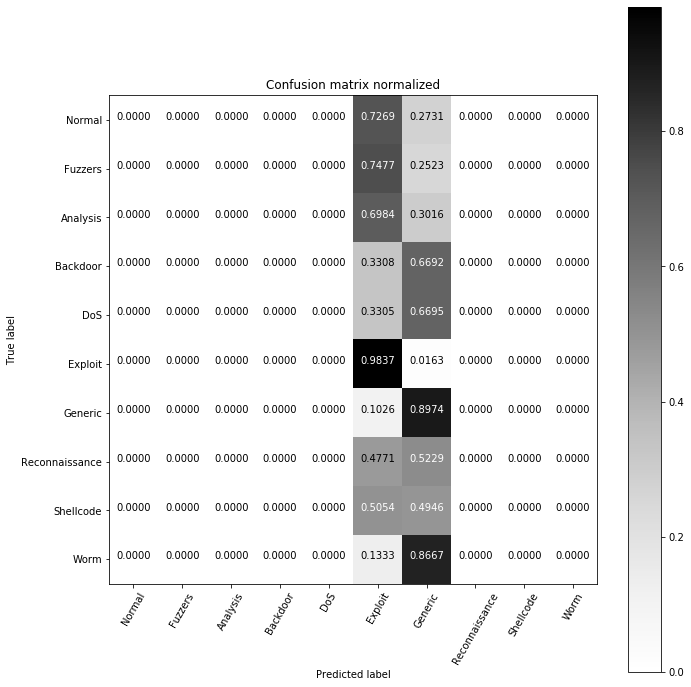

Each row adds 1 in total


In [0]:
# Measure accuracy
from sklearn.metrics import confusion_matrix
import itertools
import sys

# Confusion Matrix
def plot_confusion_matrix(cm, labels, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greys):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    plt.rcParams["figure.figsize"] = [10,10]
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=60)
        plt.yticks(tick_marks, labels)
    else:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{0:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{0:.0f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

labels = ['Normal', 'Fuzzers', 'Analysis', 'Backdoor', 'DoS', 'Exploit', 'Generic', 'Reconnaissance', 'Shellcode', 'Worm']
cm = confusion_matrix(y_eval, y_pred)
plot_confusion_matrix(cm, labels, classes=list(range(9)), normalize=False, title='Confusion matrix')
plot_confusion_matrix(cm, labels, classes=list(range(9)), normalize=True, title='Confusion matrix normalized')
print("Each row adds 1 in total")

## **TP, FP, FN, TN, FPR & TNR**

In [0]:
# TP
TP = np.diag(cm)

# FP
FP = []
for i in range(cm.shape[0]):
    FP.append(sum(cm[:,i]) - cm[i,i])

# FN    
FN = []
for i in range(cm.shape[0]):
    FN.append(sum(cm[i,:]) - cm[i,i])    

# TN
TN = []
for i in range(cm.shape[0]):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))   

# FPR, TNR
FPR = []
TNR = []
for i in range(cm.shape[0]):
    temp1 = FP[i]/(TN[i]+FP[i])
    temp2 = TN[i]/(TN[i]+FP[i])
    FPR.append(temp1)
    TNR.append(temp2)

# Printing
for i in range(cm.shape[0]):
    print(labels[i])
    print("TP: ", TP[i])
    print("FP: ", FP[i])
    print("FN: ", FN[i])
    print("TN: ", TN[i])
    print("FPR: ", FPR[i])
    print("TNR: ", TNR[i])
    print("\n")

Normal
TP:  0
FP:  0
FN:  1355
TN:  1268515
FPR:  0.0
TNR:  1.0


Fuzzers
TP:  0
FP:  0
FN:  1181
TN:  1268689
FPR:  0.0
TNR:  1.0


Analysis
TP:  0
FP:  0
FN:  8170
TN:  1261700
FPR:  0.0
TNR:  1.0


Backdoor
TP:  0
FP:  0
FN:  22207
TN:  1247663
FPR:  0.0
TNR:  1.0


DoS
TP:  0
FP:  0
FN:  12094
TN:  1257776
FPR:  0.0
TNR:  1.0


Exploit
TP:  106153
FP:  136392
FN:  1761
TN:  1025564
FPR:  0.11738138105057334
TNR:  0.8826186189494266


Generic
TP:  995372
FP:  31953
FN:  113754
TN:  128791
FPR:  0.19878191409943763
TNR:  0.8012180859005624


Reconnaissance
TP:  0
FP:  0
FN:  6995
TN:  1262875
FPR:  0.0
TNR:  1.0


Shellcode
TP:  0
FP:  0
FN:  738
TN:  1269132
FPR:  0.0
TNR:  1.0


Worm
TP:  0
FP:  0
FN:  90
TN:  1269780
FPR:  0.0
TNR:  1.0




## **ROC**

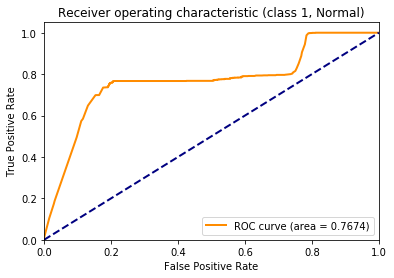

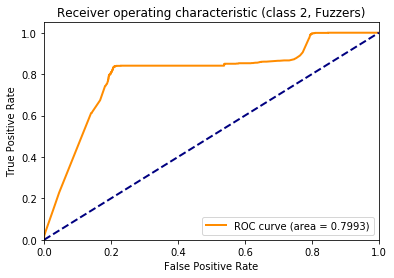

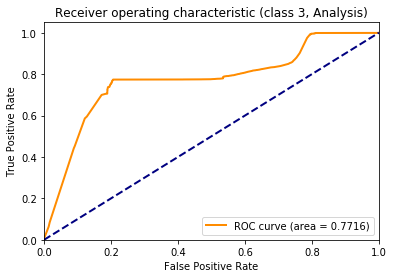

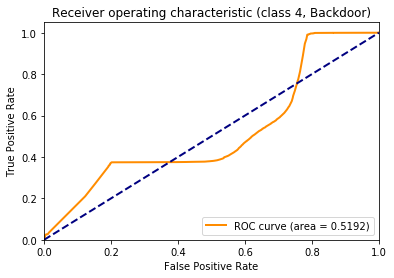

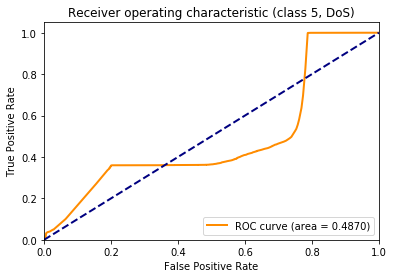

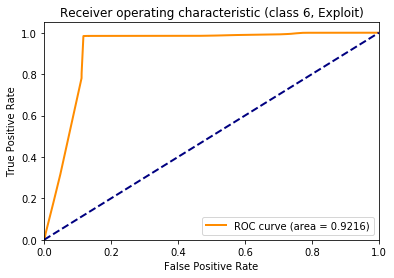

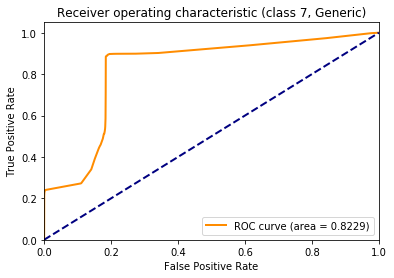

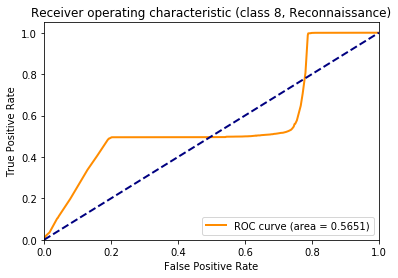

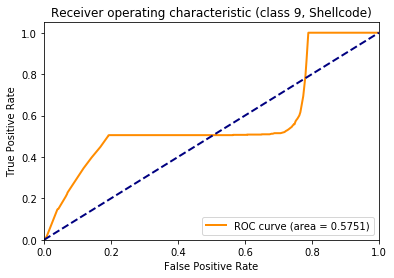

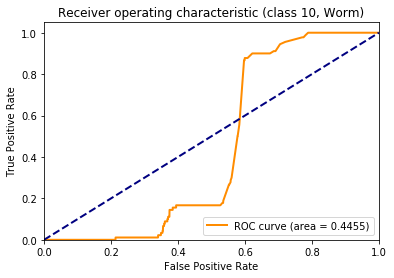

In [0]:
# ROC
def plot_roc_curve(Y_test, Y_pred, classes, labels):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test[:, i], Y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])   
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])   
    #plt.figure()
    lw = 2
    plt.rcParams["figure.figsize"] = [6,4]
    for i in range(classes):
      plt.plot(fpr[i], tpr[i], color='darkorange',
              lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver operating characteristic (class '+ str(i+1) +', '+ labels[i] +')')
      plt.legend(loc="lower right")
      plt.show()

plot_roc_curve(y_test, y_p, len(labels), labels)